# Homework 9: Bayesian Inference

Due Tuesday Apr 24, 5pm

Inferring underlying properties of physical systems is a fairly ubiquitous requirement in data-driven fields. The following problem involves inferring the motion properties of two objects given (noisy, finite #) measurements over time.

Use PyMC and Bayesian inference to answer the following questions:
- What is the posterior of the speed of each object?
- What is the 5% and 95% confidence interval of the time range when the true Y value of the Blue object is => 0 AND the true Y value of Red <=0? That is, what are the 5% and 95% quantiles of the estimated first time when Y_blue >= 0 and Y_red <= 0?
- If both objects are known to be moving at the same speed, how does you answer in a and b change? That is, that the total magnitude of the velocity (sqrt[vx2 + vy2]) is the same for each object.
- Repeat your answers for a-c by using only the first 100 measurements? Do the changes make sense?

**NOTE that this notebook can take up to 2 hours to run depending on the processors' types.** I set sampling size as 100,000, and computing the effective samples take quite a long while. Please be patient and do NOT kill the kernel. The work is replicable (though not reproducible and as everytime the sampling varies a bit, but the integer part of all values remain the same) as I have re-runned this file for more than 3 times.

In [1]:
# This does not guarantee exactly the same results everytime
# import randome
# random.seed(42)

# Data manipulation & processing
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy import stats
import theano.tensor as tt
# Graph viewing & plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('poster')
sns.set_color_codes()
%matplotlib inline

/Users/leoli/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Import & Load dataset
loc_data = pd.read_csv('./location_data_hw9_2018.csv')
print('length of the dataset:',len(loc_data))
loc_data.head()

length of the dataset: 238


,t,red_pos_X,red_pos_Y,blue_pos_X,blue_pos_Y
0,1.718397,1.330174,0.993564,1.081700,-1.295918
1,2.998056,1.310404,1.012772,1.004997,-1.254394
2,6.015073,1.270312,1.028386,1.113696,-1.321257
3,8.267651,1.331131,0.948223,1.001845,-1.285209
4,9.279321,1.346159,0.963485,1.113008,-1.261147


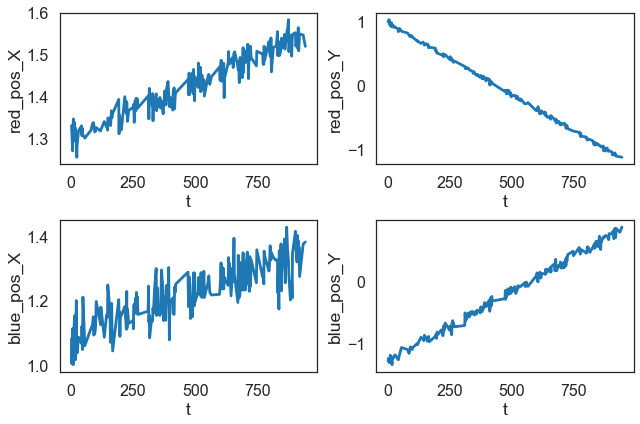

In [3]:
# Visualize the dataset by checking the scopes of positions of X/Y versus t
fig, axes = plt.subplots(2,2, figsize=[9, 6])
ylabels = [['red_pos_X', 'red_pos_Y'], ['blue_pos_X', 'blue_pos_Y']]
for i in range(2):
    for j in range(2):
        axes[i,j].plot(loc_data['t'], loc_data[ylabels[i][j]])
        axes[i,j].set_xlabel('t')
        axes[i,j].set_ylabel(ylabels[i][j])
plt.tight_layout()

In [4]:
slopes, intercepts = {}, {}
columns = ['red_pos_X', 'red_pos_Y', 'blue_pos_X', 'blue_pos_Y']
for var in columns:
    a, b, _, _, _ = stats.linregress(loc_data['t'], loc_data[var])
    slopes[var] = a
    intercepts[var] = b
    print('slope of', var, 'versus t is :', slopes[var], ', with intercept as :', intercepts[var])

slope of red_pos_X versus t is : 0.00025840233739382254 , with intercept as : 1.3023058484320011
slope of red_pos_Y versus t is : -0.0022627203622120947 , with intercept as : 0.9819136208113074
slope of blue_pos_X versus t is : 0.0002707103647621185 , with intercept as : 1.0935408554945725
slope of blue_pos_Y versus t is : 0.0022695215907676237 , with intercept as : -1.3043323792349892


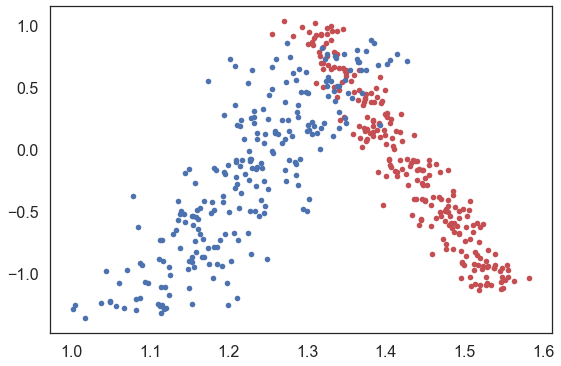

In [5]:
# Visualize the positions of red and blue objects
plt.figure(figsize=[9, 6])
plt.plot(loc_data.red_pos_X, loc_data.red_pos_Y, 'r.')
plt.plot(loc_data.blue_pos_X, loc_data.blue_pos_Y, 'b.')

### a) What is the posterior of the speed of each object?

The true positions of each object are expressed as:
$$(x,y)=(x_0+v_xt,\;y_0+v_yt)$$
The measured positions are subject to Gaussian noise:
$$(x,y)_\text{measured}=N((x,y), \Sigma)$$
at which we assume zero covariance:
$$\Sigma = \left(\begin{array}{cc}
\sigma_x & 0\\
0 & \sigma_y
\end{array}\right)$$
We choose continuous uniform random priors for the objects:
$$v_x\sim Uniform(\text{some range}) ;  v_y\sim Uniform(\text{some range})$$
and $$x_0 \sim Uniform(\text{some range}) ; y_0 \sim Uniform(\text{some range})$$

We wish to estimate the parameters $\{x_0, y_0, v_x, v_y, \sigma_x, \sigma_y\}$ for both objects.

In [6]:
with pm.Model() as model_coupled:
    t = loc_data['t']
    
    xname_red, yname_red = 'red_pos_X', 'red_pos_Y'
    xname_blue, yname_blue = 'blue_pos_X', 'blue_pos_Y'
    obs_x_red, obs_y_red = loc_data[xname_red], loc_data[yname_red]
    obs_x_blue, obs_y_blue = loc_data[xname_blue], loc_data[yname_blue]
    
    # range of vx and x0 defined by values obtained from linear regression
    vx_red = pm.Uniform('vx_red', slopes[xname_red]/5, slopes[xname_red]*5)
    x0_red = pm.Uniform('x0_red', intercepts[xname_red]-1, intercepts[xname_red]+1)
    vx_blue = pm.Uniform('vx_blue', slopes[xname_blue]/5, slopes[xname_blue]*5)
    x0_blue = pm.Uniform('x0_blue', intercepts[xname_blue]-1, intercepts[xname_blue]+1)
    
    # vy is negative
    vy_red = pm.Uniform('vy_red', slopes[yname_red]*5, slopes[yname_red]/5)
    y0_red = pm.Uniform('y0_red', intercepts[yname_red]-1, intercepts[yname_red]+1)    
    vy_blue = pm.Uniform('vy_blue', slopes[yname_blue]/5, slopes[yname_blue]*5)
    y0_blue = pm.Uniform('y0_blue', intercepts[yname_blue]-1, intercepts[yname_blue]+1)    
    
    # define speed
    v_red = pm.Deterministic('v_red', tt.sqrt(vx_red**2 + vy_red**2))
    v_blue = pm.Deterministic('v_blue', tt.sqrt(vx_blue**2 + vy_blue**2))

    # pre-define likelihood
    sigma_x_red = pm.Uniform('sigma_x_red', 0, 1)
    sigma_y_red = pm.Uniform('sigma_y_red', 0, 1)
    sigma_x_blue = pm.Uniform('sigma_x_blue', 0, 1)
    sigma_y_blue = pm.Uniform('sigma_y_blue', 0, 1)
    
    mu_x_red = pm.Deterministic('mu_x_red', vx_red*t+x0_red)
    mu_y_red = pm.Deterministic('mu_y_red', vy_red*t+y0_red)    
    mu_x_blue = pm.Deterministic('mu_x_blue', vx_blue*t+x0_blue)
    mu_y_blue = pm.Deterministic('mu_y_blue', vy_blue*t+y0_blue)    

In [7]:
# This cell would take a very long while to run
# Even when the progress bar shows finished by 100%
# The kernel is still busy with computingt the effective samples amount
N = 100000

with model_coupled:
    # define likelihood
    mc_x_red = pm.Normal("mc_x_red", mu_x_red, sigma_x_red, observed=obs_x_red)
    mc_y_red = pm.Normal("mc_y_red", mu_y_red, sigma_y_red, observed=obs_y_red)
    mc_x_blue = pm.Normal("mc_x_blue", mu_x_blue, sigma_x_blue, observed=obs_x_blue)
    mc_y_blue = pm.Normal("mc_y_blue", mu_y_blue, sigma_y_blue, observed=obs_y_blue)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(N, step=step, start=start)
    burned_trace = trace[50000::5]

logp = 1,975.4, ||grad|| = 1.1805: 100%|██████████| 140/140 [00:00<00:00, 1220.25it/s] 
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma_y_blue_interval__]
>Metropolis: [sigma_x_blue_interval__]
>Metropolis: [sigma_y_red_interval__]
>Metropolis: [sigma_x_red_interval__]
>Metropolis: [y0_blue_interval__]
>Metropolis: [vy_blue_interval__]
>Metropolis: [y0_red_interval__]
>Metropolis: [vy_red_interval__]
>Metropolis: [x0_blue_interval__]
>Metropolis: [vx_blue_interval__]
>Metropolis: [x0_red_interval__]
>Metropolis: [vx_red_interval__]
100%|██████████| 100500/100500 [07:02<00:00, 237.84it/s]
The number of effective samples is smaller than 10% for some parameters.


**posterior of red speed**

Mean: Red: 0.0022773517189323043
5% quantile: Red: 0.0022698021689607204
95% quantile: Red: 0.0022848692935283077


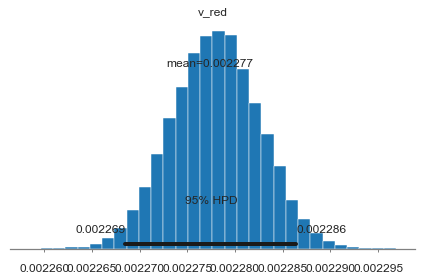

In [8]:
v_r_pos = burned_trace['v_red']
print('Mean: Red:', np.mean(v_r_pos))
print('5% quantile: Red:', np.percentile(v_r_pos, 5))
print('95% quantile: Red:', np.percentile(v_r_pos, 95))
# Coult NOT figure how to set the label sizes
pm.plots.plot_posterior(burned_trace, figsize = [6, 4], varnames=['v_red'], round_to=6, alpha_level=0.05)

**posterior of blue speed**

Mean: Blue: 0.0022858258349857186
5% quantile: Blue: 0.0022666975040552657
95% quantile: Blue: 0.0023047484611705784


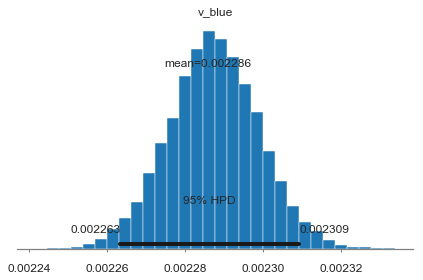

In [9]:
v_b_pos = burned_trace['v_blue']
print('Mean: Blue:', np.mean(v_b_pos))
print('5% quantile: Blue:', np.percentile(v_b_pos, 5))
print('95% quantile: Blue:', np.percentile(v_b_pos, 95))
# Coult NOT figure how to set the label sizes
pm.plots.plot_posterior(burned_trace, figsize = [6, 4], varnames=['v_blue'], round_to=6, alpha_level=0.05)

The red points have a velocity of $(2.277\pm 0.008)\times 10^{-3}$, and the blue points have velocity of $(2.286\pm 0.02)\times 10^{-3}$

### b) What is the 5% and 95% confidence interval of the time range when the true Y value of the Blue object is => 0 AND the true Y value of Red <=0? That is, what are the 5% and 95% quantiles of the estimated first time when Y_blue >= 0 and Y_red <= 0?

100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


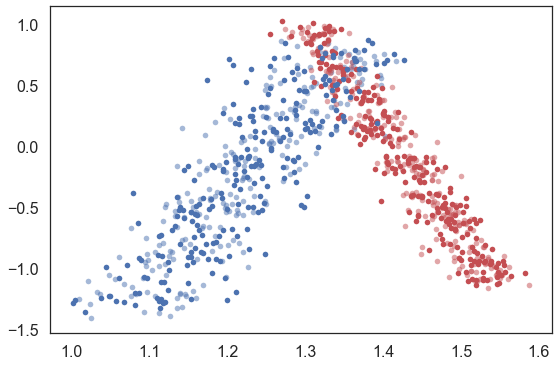

In [10]:
# Visualize the positions of red and blue objects
plt.figure(figsize=(9, 6))
realizations = pm.sample_ppc(trace=burned_trace, model=model_coupled, samples=1)
plt.plot(realizations['mc_x_blue'], realizations['mc_y_blue'], 'b.', alpha=0.5); # might be the true positions
plt.plot(realizations['mc_x_red'], realizations['mc_y_red'], 'r.', alpha=0.5); # might be the true positions
plt.plot(loc_data.red_pos_X, loc_data.red_pos_Y, 'r.'); # measured & recorded positions
plt.plot(loc_data.blue_pos_X, loc_data.blue_pos_Y, 'b.'); # measured & recorded positions

Now compute the first time the red and blue object meet/cross, i.e. $t_R$ and $t_B$ where

$$y_{0,red}+v_{red}t_{red}=0\text{  and  } y_{0,blue}+v_{blue}t_{blue}=0,$$

or

$$t_{red}=\frac{-y_{0,red}}{v_{red}}\text{  and  }t_{blue}=\frac{-y_{0,blue}}{v_{blue}}$$

Mean: First_Time: 574.7204603749178
5% quantile: First_Time: 572.3237370219413
95% quantile: First_Time: 577.1228127028191


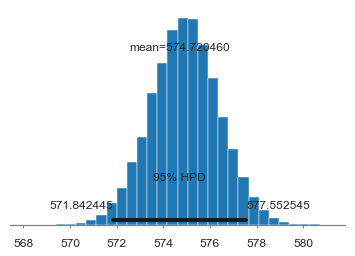

In [11]:
t_red = -burned_trace["y0_red"]/burned_trace["vy_red"]
t_blue = -burned_trace["y0_blue"]/burned_trace["vy_blue"]
tau = np.max(np.array([t_red, t_blue]), axis=0)
print('Mean: First_Time:', np.mean(tau))
print('5% quantile: First_Time:', np.percentile(tau, 5))
print('95% quantile: First_Time:', np.percentile(tau, 95))
pm.plots.plot_posterior(trace=tau, figsize = [6, 4], alpha_level=0.05, round_to=6)

### c) If both objects are known to be moving at the same speed, how does you answer in a and b change? That is, that the total magnitude of the velocity (sqrt[vx2 + vy2]) is the same for each object.

Mostly similar to the model above, but notice that now `vy_red` is no longer an independent random variable! It's not dependent on `vx_red`.

In [12]:
with pm.Model() as model_coupled_shared:
    t = loc_data['t']
    
    xname_red, yname_red = 'red_pos_X', 'red_pos_Y'
    xname_blue, yname_blue = 'blue_pos_X', 'blue_pos_Y'
    obs_x_red, obs_y_red = loc_data[xname_red], loc_data[yname_red]
    obs_x_blue, obs_y_blue = loc_data[xname_blue], loc_data[yname_blue]
    
    # range of vx and x0 defined by values obtained from linear regression
    vx_red = pm.Uniform('vx_red', slopes[xname_red]/5, slopes[xname_red]*5)
    x0_red = pm.Uniform('x0_red', intercepts[xname_red]-1, intercepts[xname_red]+1)
    vx_blue = pm.Uniform('vx_blue', slopes[xname_blue]/5, slopes[xname_blue]*5)
    x0_blue = pm.Uniform('x0_blue', intercepts[xname_blue]-1, intercepts[xname_blue]+1)
    
    # vy is negative
    y0_red = pm.Uniform('y0_red', intercepts[yname_red]-1, intercepts[yname_red]+1)    
    vy_blue = pm.Uniform('vy_blue', slopes[yname_blue]/5, slopes[yname_blue]*5)
    y0_blue = pm.Uniform('y0_blue', intercepts[yname_blue]-1, intercepts[yname_blue]+1)    
    
    # define speed
    v_shared = pm.Deterministic('v_shared', tt.sqrt(vx_blue**2 + vy_blue**2))

    # vy_red is no longer independent; it's dependent on vx_red now
    # vy_red is still negative
    vy_red_i = pm.Deterministic('vy_red_i', -tt.sqrt(v_shared**2 - vx_red**2))
    
    # pre-define likelihood
    sigma_x_red = pm.Uniform('sigma_x_red', 0, 1)
    sigma_y_red = pm.Uniform('sigma_y_red', 0, 1)
    sigma_x_blue = pm.Uniform('sigma_x_blue', 0, 1)
    sigma_y_blue = pm.Uniform('sigma_y_blue', 0, 1)
    
    mu_x_red = pm.Deterministic('mu_x_red', vx_red*t+x0_red)
    mu_y_red_i = pm.Deterministic('mu_y_red_i', vy_red_i*t+y0_red)    
    mu_x_blue = pm.Deterministic('mu_x_blue', vx_blue*t+x0_blue)
    mu_y_blue = pm.Deterministic('mu_y_blue', vy_blue*t+y0_blue)    

In [13]:
# This cell would take a very long while to run
# Even when the progress bar shows finished by 100%
# The kernel is still busy with computingt the effective samples amount
N = 100000

with model_coupled_shared:
    # define likelihood
    mc_x_red = pm.Normal("mc_x_red", mu_x_red, sigma_x_red, observed=obs_x_red)
    mc_y_red_i = pm.Normal("mc_y_red_i", mu_y_red_i, sigma_y_red, observed=obs_y_red)
    mc_x_blue = pm.Normal("mc_x_blue", mu_x_blue, sigma_x_blue, observed=obs_x_blue)
    mc_y_blue = pm.Normal("mc_y_blue", mu_y_blue, sigma_y_blue, observed=obs_y_blue)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(N, step=step, start=start)
    burned_trace = trace[50000::5]

logp = 1,970.7, ||grad|| = 3.7067: 100%|██████████| 115/115 [00:00<00:00, 1334.79it/s]        
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma_y_blue_interval__]
>Metropolis: [sigma_x_blue_interval__]
>Metropolis: [sigma_y_red_interval__]
>Metropolis: [sigma_x_red_interval__]
>Metropolis: [y0_blue_interval__]
>Metropolis: [vy_blue_interval__]
>Metropolis: [y0_red_interval__]
>Metropolis: [x0_blue_interval__]
>Metropolis: [vx_blue_interval__]
>Metropolis: [x0_red_interval__]
>Metropolis: [vx_red_interval__]
100%|██████████| 100500/100500 [05:34<00:00, 300.48it/s]
The number of effective samples is smaller than 10% for some parameters.


**posterior of shared speed**

Mean: Shared_Speed: 0.002278578584956698
5% quantile: Shared_Speed: 0.0022716331901130793
95% quantile: Shared_Speed: 0.0022855023747509555


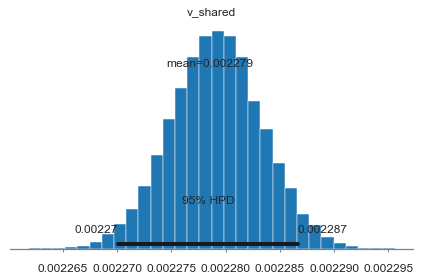

In [14]:
v_shared = burned_trace['v_shared']
print('Mean: Shared_Speed:', np.mean(v_shared))
print('5% quantile: Shared_Speed:', np.percentile(v_shared, 5))
print('95% quantile: Shared_Speed:', np.percentile(v_shared, 95))
# Coult NOT figure how to set the label sizes
pm.plots.plot_posterior(burned_trace, figsize = [6, 4], varnames=['v_shared'], round_to=6, alpha_level=0.05)

The shared speed for two objects $(2.279\times 10^{-3})$ lies in between the speeds of each object $(2.277\times 10^{-3}, 2.286\times10^{-3})$

**First time of encounter**

Mean: First_Time: 574.9966953509603
5% quantile: First_Time: 572.7197732824618
95% quantile: First_Time: 577.2889398313946


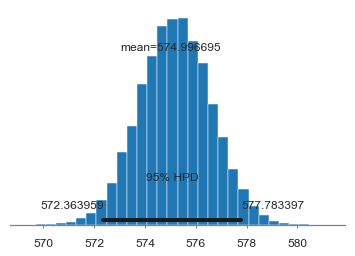

In [15]:
t_red = -burned_trace["y0_red"]/burned_trace["vy_red_i"]
t_blue = -burned_trace["y0_blue"]/burned_trace["vy_blue"]
tau = np.max(np.array([t_red, t_blue]), axis=0)
print('Mean: First_Time:', np.mean(tau))
print('5% quantile: First_Time:', np.percentile(tau, 5))
print('95% quantile: First_Time:', np.percentile(tau, 95))
pm.plots.plot_posterior(trace=tau, figsize = [6, 4], alpha_level=0.05, round_to=6)

Previously we had "Mean: First_Time: 574.7204603749178; 5% quantile: First_Time: 572.3237370219413; 95% quantile: First_Time: 577.1228127028191". All values are within $\pm 0.30$ range. Essentially, answers in a) and b) don't change, but slightly vary.

### d) Repeat your answers for a-c by using only the first 100 measurements? Do the changes make sense?

In [16]:
# Slice the first 100 elements from dataset
loc_data_100 = loc_data[: 100]
print('length of the dataset:',len(loc_data_100))
loc_data_100.head()

length of the dataset: 100


,t,red_pos_X,red_pos_Y,blue_pos_X,blue_pos_Y
0,1.718397,1.330174,0.993564,1.081700,-1.295918
1,2.998056,1.310404,1.012772,1.004997,-1.254394
2,6.015073,1.270312,1.028386,1.113696,-1.321257
3,8.267651,1.331131,0.948223,1.001845,-1.285209
4,9.279321,1.346159,0.963485,1.113008,-1.261147


In [17]:
slopes_100, intercepts_100 = {}, {}
# columns = ['red_pos_X', 'red_pos_Y', 'blue_pos_X', 'blue_pos_Y']
for var in columns:
    a, b, _, _, _ = stats.linregress(loc_data_100['t'], loc_data_100[var])
    slopes_100[var] = a
    intercepts_100[var] = b
    print('slope of', var, 'versus t is :', slopes_100[var], ', with intercept as :', intercepts_100[var])

slope of red_pos_X versus t is : 0.00023268099525453542 , with intercept as : 1.3068992530547967
slope of red_pos_Y versus t is : -0.002247874172479211 , with intercept as : 0.9795239431466274
slope of blue_pos_X versus t is : 0.00027711000921464327 , with intercept as : 1.091744236393187
slope of blue_pos_Y versus t is : 0.002250233763751504 , with intercept as : -1.3005647728741818


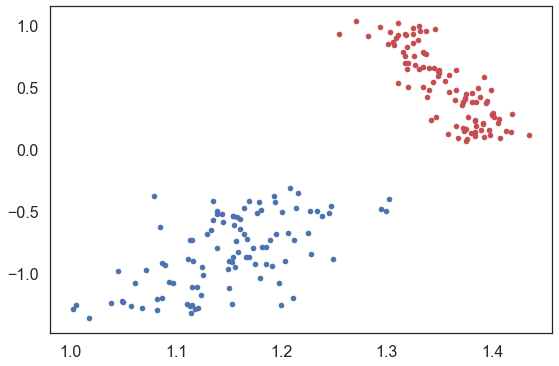

In [18]:
# Visualize the positions of first 100 red and blue objects
plt.figure(figsize=[9, 6])
plt.plot(loc_data_100.red_pos_X, loc_data_100.red_pos_Y, 'r.')
plt.plot(loc_data_100.blue_pos_X, loc_data_100.blue_pos_Y, 'b.')

**posterior of blue speed, red speed and first encounter time**

In [19]:
with pm.Model() as model_coupled_100:
    t_100 = loc_data_100['t']
    
    xname_red, yname_red = 'red_pos_X', 'red_pos_Y'
    xname_blue, yname_blue = 'blue_pos_X', 'blue_pos_Y'
    obs_x_red_100, obs_y_red_100 = loc_data_100[xname_red], loc_data_100[yname_red]
    obs_x_blue_100, obs_y_blue_100 = loc_data_100[xname_blue], loc_data_100[yname_blue]
    
    # range of vx and x0 defined by values obtained from linear regression
    vx_red_100 = pm.Uniform('vx_red_100', slopes_100[xname_red]/5, slopes_100[xname_red]*5)
    x0_red_100 = pm.Uniform('x0_red_100', intercepts_100[xname_red]-1, intercepts_100[xname_red]+1)
    vx_blue_100 = pm.Uniform('vx_blue_100', slopes_100[xname_blue]/5, slopes_100[xname_blue]*5)
    x0_blue_100 = pm.Uniform('x0_blue_100', intercepts_100[xname_blue]-1, intercepts_100[xname_blue]+1)
    
    # vy is negative
    vy_red_100 = pm.Uniform('vy_red_100', slopes_100[yname_red]*5, slopes_100[yname_red]/5)
    y0_red_100 = pm.Uniform('y0_red_100', intercepts_100[yname_red]-1, intercepts_100[yname_red]+1)    
    vy_blue_100 = pm.Uniform('vy_blue_100', slopes_100[yname_blue]/5, slopes_100[yname_blue]*5)
    y0_blue_100 = pm.Uniform('y0_blue_100', intercepts_100[yname_blue]-1, intercepts_100[yname_blue]+1)    
    
    # define speed
    v_red_100 = pm.Deterministic('v_red_100', tt.sqrt(vx_red_100**2 + vy_red_100**2))
    v_blue_100 = pm.Deterministic('v_blue_100', tt.sqrt(vx_blue_100**2 + vy_blue_100**2))

    # pre-define likelihood
    sigma_x_red = pm.Uniform('sigma_x_red', 0, 1)
    sigma_y_red = pm.Uniform('sigma_y_red', 0, 1)
    sigma_x_blue = pm.Uniform('sigma_x_blue', 0, 1)
    sigma_y_blue = pm.Uniform('sigma_y_blue', 0, 1)
    
    mu_x_red_100 = pm.Deterministic('mu_x_red_100', vx_red_100*t_100+x0_red_100)
    mu_y_red_100 = pm.Deterministic('mu_y_red_100', vy_red_100*t_100+y0_red_100)    
    mu_x_blue_100 = pm.Deterministic('mu_x_blue_100', vx_blue_100*t_100+x0_blue_100)
    mu_y_blue_100 = pm.Deterministic('mu_y_blue_100', vy_blue_100*t_100+y0_blue_100)    

In [20]:
# This cell would take a very long while to run
# Even when the progress bar shows finished by 100%
# The kernel is still busy with computingt the effective samples amount
N = 100000

with model_coupled_100:
    # define likelihood
    mc_x_red_100 = pm.Normal("mc_x_red_100", mu_x_red_100, sigma_x_red, observed=obs_x_red_100)
    mc_y_red_100 = pm.Normal("mc_y_red_100", mu_y_red_100, sigma_y_red, observed=obs_y_red_100)
    mc_x_blue_100 = pm.Normal("mc_x_blue_100", mu_x_blue_100, sigma_x_blue, observed=obs_x_blue_100)
    mc_y_blue_100 = pm.Normal("mc_y_blue_100", mu_y_blue_100, sigma_y_blue, observed=obs_y_blue_100)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace_100 = pm.sample(N, step=step, start=start)
    burned_trace_100 = trace_100[50000::5]

logp = 854.4, ||grad|| = 0.13206: 100%|██████████| 105/105 [00:00<00:00, 1057.77it/s]        
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma_y_blue_interval__]
>Metropolis: [sigma_x_blue_interval__]
>Metropolis: [sigma_y_red_interval__]
>Metropolis: [sigma_x_red_interval__]
>Metropolis: [y0_blue_100_interval__]
>Metropolis: [vy_blue_100_interval__]
>Metropolis: [y0_red_100_interval__]
>Metropolis: [vy_red_100_interval__]
>Metropolis: [x0_blue_100_interval__]
>Metropolis: [vx_blue_100_interval__]
>Metropolis: [x0_red_100_interval__]
>Metropolis: [vx_red_100_interval__]
100%|██████████| 100500/100500 [05:41<00:00, 293.96it/s]
The number of effective samples is smaller than 10% for some parameters.


Mean: Red_100: 0.002259552493206787
5% quantile: Red_100: 0.002235634709549927
95% quantile: Red_100: 0.002283308157921905


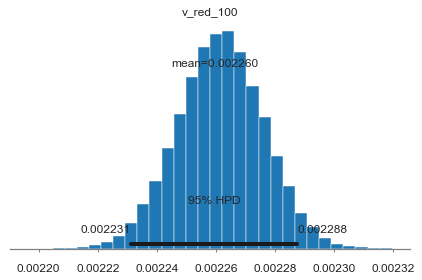

In [21]:
v_r_pos_100 = burned_trace_100['v_red_100']
print('Mean: Red_100:', np.mean(v_r_pos_100))
print('5% quantile: Red_100:', np.percentile(v_r_pos_100, 5))
print('95% quantile: Red_100:', np.percentile(v_r_pos_100, 95))
# Coult NOT figure how to set the label sizes
pm.plots.plot_posterior(burned_trace_100, figsize = [6, 4], varnames=['v_red_100'], round_to=6, alpha_level=0.05)

Mean: Blue_100: 0.0022679436416865855
5% quantile: Blue_100: 0.0022093118978534026
95% quantile: Blue_100: 0.0023278374012887914


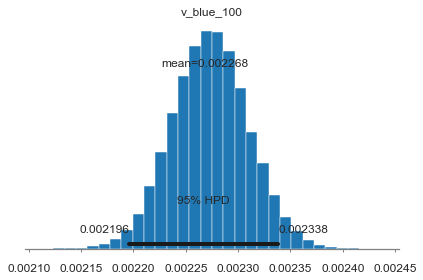

In [23]:
v_b_pos_100 = burned_trace_100['v_blue_100']
print('Mean: Blue_100:', np.mean(v_b_pos_100))
print('5% quantile: Blue_100:', np.percentile(v_b_pos_100, 5))
print('95% quantile: Blue_100:', np.percentile(v_b_pos_100, 95))
# Coult NOT figure how to set the label sizes
pm.plots.plot_posterior(burned_trace_100, figsize = [6, 4], varnames=['v_blue_100'], round_to=6, alpha_level=0.05)

Mean: First_Time_100: 577.9960564165607
5% quantile: First_Time_100: 567.8163965305894
95% quantile: First_Time_100: 588.3902740927105


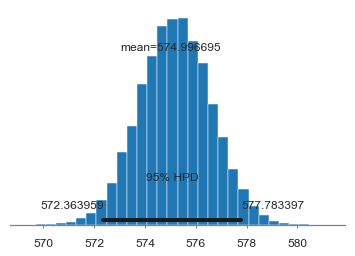

In [24]:
t_red_100 = -burned_trace_100["y0_red_100"]/burned_trace_100["vy_red_100"]
t_blue_100 = -burned_trace_100["y0_blue_100"]/burned_trace_100["vy_blue_100"]
tau_100 = np.max(np.array([t_red_100, t_blue_100]), axis=0)
print('Mean: First_Time_100:', np.mean(tau_100))
print('5% quantile: First_Time_100:', np.percentile(tau_100, 5))
print('95% quantile: First_Time_100:', np.percentile(tau_100, 95))
pm.plots.plot_posterior(trace=tau, figsize = [6, 4], alpha_level=0.05, round_to=6)

The red points have a velocity of $(2.260\pm 0.025)\times 10^{-3}$, and the blue points have velocity of $(2.268\pm 0.06)\times 10^{-3}$, whereas previously we had the red points with a velocity of $(2.277\pm 0.008)\times 10^{-3}$, and the blue points with a velocity of $(2.286\pm 0.02)\times 10^{-3}$


For first time of encounter, previously we had "Mean: First_Time: 574.7204603749178; 5% quantile: First_Time: 572.3237370219413; 95% quantile: First_Time: 577.1228127028191". Now we have "Mean: First_Time_100: 577.9960564165607; 5% quantile: First_Time_100: 567.8163965305894; 95% quantile: First_Time_100: 588.3902740927105". The mean value stays close to the one before, but the uncertainties have increased a lot (from $\pm2.5$ to $\pm10.5$).

**posterior of shared speed & first encounter time**

In [25]:
with pm.Model() as model_coupled_100:
    t_100 = loc_data_100['t']
    
    xname_red, yname_red = 'red_pos_X', 'red_pos_Y'
    xname_blue, yname_blue = 'blue_pos_X', 'blue_pos_Y'
    obs_x_red_100, obs_y_red_100 = loc_data_100[xname_red], loc_data_100[yname_red]
    obs_x_blue_100, obs_y_blue_100 = loc_data_100[xname_blue], loc_data_100[yname_blue]
    
    # range of vx and x0 defined by values obtained from linear regression
    vx_red_100 = pm.Uniform('vx_red_100', slopes_100[xname_red]/5, slopes_100[xname_red]*5)
    x0_red_100 = pm.Uniform('x0_red_100', intercepts_100[xname_red]-1, intercepts_100[xname_red]+1)
    vx_blue_100 = pm.Uniform('vx_blue_100', slopes_100[xname_blue]/5, slopes_100[xname_blue]*5)
    x0_blue_100 = pm.Uniform('x0_blue_100', intercepts_100[xname_blue]-1, intercepts_100[xname_blue]+1)
    
    # vy is negative
    y0_red_100 = pm.Uniform('y0_red_100', intercepts_100[yname_red]-1, intercepts_100[yname_red]+1)    
    vy_blue_100 = pm.Uniform('vy_blue_100', slopes_100[yname_blue]/5, slopes_100[yname_blue]*5)
    y0_blue_100 = pm.Uniform('y0_blue_100', intercepts_100[yname_blue]-1, intercepts_100[yname_blue]+1)    
    
    # define speed
    v_shared_100 = pm.Deterministic('v_shared_100', tt.sqrt(vx_blue_100**2 + vy_blue_100**2))
    
    # vy_red is no longer independent; it's dependent on vx_red now
    # vy_red is still negative
    vy_red_i_100 = pm.Deterministic('vy_red_i_100', -tt.sqrt(v_shared_100**2 - vx_red_100**2))

    # pre-define likelihood
    sigma_x_red = pm.Uniform('sigma_x_red', 0, 1)
    sigma_y_red = pm.Uniform('sigma_y_red', 0, 1)
    sigma_x_blue = pm.Uniform('sigma_x_blue', 0, 1)
    sigma_y_blue = pm.Uniform('sigma_y_blue', 0, 1)
    
    mu_x_red_100 = pm.Deterministic('mu_x_red_100', vx_red_100*t_100+x0_red_100)
    mu_y_red_i_100 = pm.Deterministic('mu_y_red_i_100', vy_red_i_100*t_100+y0_red_100)    
    mu_x_blue_100 = pm.Deterministic('mu_x_blue_100', vx_blue_100*t_100+x0_blue_100)
    mu_y_blue_100 = pm.Deterministic('mu_y_blue_100', vy_blue_100*t_100+y0_blue_100)    

In [28]:
# This cell would take a very long while to run
# Even when the progress bar shows finished by 100%
# The kernel is still busy with computingt the effective samples amount
N = 100000

with model_coupled_100:
    # define likelihood
    mc_x_red_100 = pm.Normal("mc_x_red_100", mu_x_red_100, sigma_x_red, observed=obs_x_red_100)
    mc_y_red_i_100 = pm.Normal("mc_y_red_i_100", mu_y_red_i_100, sigma_y_red, observed=obs_y_red_100)
    mc_x_blue_100 = pm.Normal("mc_x_blue_100", mu_x_blue_100, sigma_x_blue, observed=obs_x_blue_100)
    mc_y_blue_100 = pm.Normal("mc_y_blue_100", mu_y_blue_100, sigma_y_blue, observed=obs_y_blue_100)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace_100 = pm.sample(N, step=step, start=start)
    burned_trace_100 = trace_100[50000::5]

logp = 849.85, ||grad|| = 0.24583: 100%|██████████| 124/124 [00:00<00:00, 1316.02it/s] 
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma_y_blue_interval__]
>Metropolis: [sigma_x_blue_interval__]
>Metropolis: [sigma_y_red_interval__]
>Metropolis: [sigma_x_red_interval__]
>Metropolis: [y0_blue_100_interval__]
>Metropolis: [vy_blue_100_interval__]
>Metropolis: [y0_red_100_interval__]
>Metropolis: [x0_blue_100_interval__]
>Metropolis: [vx_blue_100_interval__]
>Metropolis: [x0_red_100_interval__]
>Metropolis: [vx_red_100_interval__]
100%|██████████| 100500/100500 [04:51<00:00, 344.71it/s]
The number of effective samples is smaller than 10% for some parameters.


Mean: Shared_Speed_100: 0.002260862369956176
5% quantile: Shared_Speed_100: 0.0022392234675914025
95% quantile: Shared_Speed_100: 0.002282433184430586


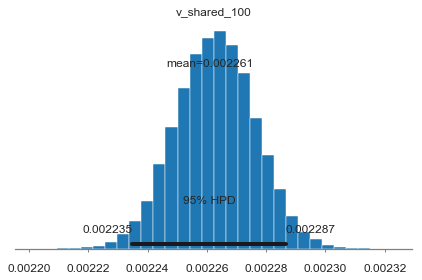

In [30]:
v_shared_100 = burned_trace_100['v_shared_100']
print('Mean: Shared_Speed_100:', np.mean(v_shared_100))
print('5% quantile: Shared_Speed_100:', np.percentile(v_shared_100, 5))
print('95% quantile: Shared_Speed_100:', np.percentile(v_shared_100, 95))
# Coult NOT figure how to set the label sizes
pm.plots.plot_posterior(burned_trace_100, figsize = [6, 4], varnames=['v_shared_100'], round_to=6, alpha_level=0.05)

Mean: First_Time_100: 579.0367836239535
5% quantile: First_Time_100: 573.9515210854925
95% quantile: First_Time_100: 584.1503498353396


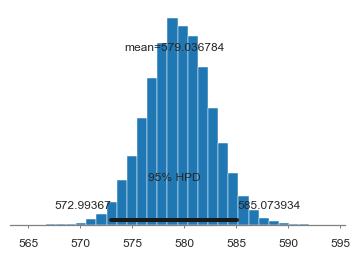

In [32]:
t_red_100 = -burned_trace_100["y0_red_100"]/burned_trace_100["vy_red_i_100"]
t_blue_100 = -burned_trace_100["y0_blue_100"]/burned_trace_100["vy_blue_100"]
tau_100 = np.max(np.array([t_red_100, t_blue_100]), axis=0)
print('Mean: First_Time_100:', np.mean(tau_100))
print('5% quantile: First_Time_100:', np.percentile(tau_100, 5))
print('95% quantile: First_Time_100:', np.percentile(tau_100, 95))
pm.plots.plot_posterior(trace=tau_100, figsize = [6, 4], alpha_level=0.05, round_to=6)

Similar to the conclusion we found above, previously with whole dataset, the "Mean: Shared_Speed: 0.002278578584956698; 5% quantile: Shared_Speed: 0.0022716331901130793; 95% quantile: Shared_Speed: 0.0022855023747509555". And now with 100 elements, we have "Mean: Shared_Speed_100: 0.002260862369956176; 5% quantile: Shared_Speed_100: 0.0022392234675914025; 95% quantile: Shared_Speed_100: 0.002282433184430586". 

Similar pattern seen in First_Time with shared speed. Mean value changes from "Mean: First_Time: 574.9966953509603" to "Mean: First_Time_100: 579.0367836239535" and uncertainties range much more widely.